## Usage
Like a regular notebook:
- __run a cell__ with **_ctrl-enter_** or **_shift-enter_**
- __use the command palette__ with **_ctrl-shift-P_** to find more complex commands

Use it only with __Chrome__

In [1]:
# tensorflow update
!pip install tensorflow==2.0.0

     |████████████████████████████████| 86.3MB 39kB/s 
     |████████████████████████████████| 3.8MB 50.4MB/s 
     |████████████████████████████████| 450kB 44.8MB/s 
     |████████████████████████████████| 81kB 7.4MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.1 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled

In [2]:
import os
import datetime
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, MinMaxScaler

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Session 2

This introduction will altern theory & practice, and will be divided as follow:
0. Reminder 
1. Download and clean data
2. Create neural network using keras
4. Model optimization
  * Batch size
  * Momentum
  * RMSProp
  * Adam
5. Regularization techniques
  *   L2 regularization
  *   Dropout
  *   Batch normalization

6. Exercice






## 1. Download and clean data

Let's download datasets

In [3]:
def download_data():
    import urllib.request
    import os
    folder = './data'
    list_urls = [
        #('https://bendrive.s3-eu-west-1.amazonaws.com/test_set.csv', 'test_set.csv'),
        #('https://bendrive.s3-eu-west-1.amazonaws.com/test_set_with_rating.csv', 'test_set_with_rating.csv'),
        ('https://bendrive.s3-eu-west-1.amazonaws.com/train_set.csv', 'train_set.csv')
        
    ]
    if not os.path.isdir(folder):
        os.mkdir(folder)
    for url, file in list_urls:
        if not os.path.isfile(folder + '/' + file):
            print("Downloading .. ", file)
            urllib.request.urlretrieve(url, folder + '/' + file)

download_data()

*With* pandas, load the datasets into dataframes

In [ ]:
import pandas as pd


df_data = pd.read_csv("./data/train_set.csv")

Load only a part of the train data for convenience

In [5]:
df_data = df_data[0:30000]
df_data.head(1)

,review,rating,user_id,business_id,useful_review,funny_review,cool_review,name_restaurant,address,city,state,postal_code,latitude,longitude,review_count_restaurant,is_open,name_user,review_count_user,yelping_since,useful_user,funny_user,cool_user,elite,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_photos
0,"Like walking back in time, every Saturday morn...",4.0,FIk4lQQu1eTe2EpzQ4xhBA,8mIrX_LrOnAqWsB5JrOojQ,0.0,0.0,0.0,Pinball Hall Of Fame,1610 E Tropicana Ave,Las Vegas,NV,89119.0,36.101449,-115.130511,1258.0,1.0,Carol,866.0,2010-08-26 22:09:14,1635.0,314.0,726.0,"2011,2012,2013,2014,2015,2016,2017,2018",63.0,4.16,18.0,10.0,3.0,2.0,2.0,29.0,26.0,53.0,53.0,15.0


Bin the target into bad review and good review

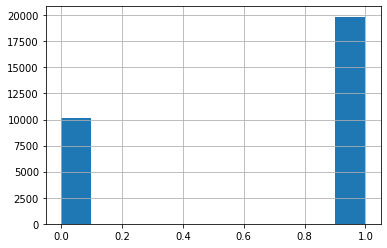

In [ ]:
pd.set_option('display.max_colwidth', -1)

# Remove empty review
df_data = df_data[['review', 'rating']].dropna()

# Convert target as integer
df_data['rating'] = df_data['rating'].astype('int')

# Create the new binary target
df_data['bin_rating'] = df_data['rating'].apply(lambda x: 1 if x > 3 else 0)

df_data["bin_rating"].hist()

In [ ]:
def convert_text_to_lowercase(df, colname):
    df[colname] = df[colname].str.lower()
    return df
    
def not_regex(pattern):
        return r"((?!{}).)".format(pattern)

def remove_punctuation(df, colname):
    df[colname] = df[colname].str.replace('\n', ' ')
    df[colname] = df[colname].str.replace('\r', ' ')
    alphanumeric_characters_extended = '(\\b[-/]\\b|[a-zA-Z0-9])'
    df[colname] = df[colname].str.replace(not_regex(alphanumeric_characters_extended), ' ')
    return df

def tokenize_sentence(df, colname):
    df[colname] = df[colname].str.split()
    return df

def remove_stop_words(df, colname):
    stop_words = stopwords.words('english')
    df[colname] = df[colname].apply(lambda x: [word for word in x if word not in stop_words])
    return df

def reverse_tokenize_sentence(df, colname):
    df[colname] = df[colname].map(lambda word: ' '.join(word))
    return df


def text_cleaning(df, colname):
    """
    Takes in a string of text, then performs the following:
    1. convert text to lowercase
    2. remove punctuation and new line characters '\n'
    3. Tokenize sentences
    4. Remove all stopwords
    5. convert tokenized text to text
    """
    df = (
        df
        .pipe(convert_text_to_lowercase, colname)
        .pipe(remove_punctuation, colname)
        .pipe(tokenize_sentence, colname)
        .pipe(remove_stop_words, colname)
        .pipe(reverse_tokenize_sentence, colname)
    )
    return df

In [ ]:
df_cleaned = text_cleaning(df_data, 'review')

df_cleaned.sample(1)

,review,rating,bin_rating
26299,hid-den gem hid-den gem n nwell maybe hidden since wait 15 minutes table even reservation place really look like hole wall vegas several times never heard place even though steps strip n nthe decor kind cheesy service impeccable food absolutely delicious seriously drink wine garlic bread soup/salad side pasta every entree 30 one best deals anywhere let alone vegas n ni got sauteed salmon fish really fresh sauce delicious tried bites lot friends pasta dishes absolutely everything tried outstanding really expecting much food kind thought going cool experience anything else pleasantly surprised n nthe accordion player absolutely adorable also,5,1


In [ ]:
TARGET = 'bin_rating'
FEATURE = 'review'

x_train, x_test, y_train, y_test = train_test_split(
    df_cleaned[FEATURE], 
    df_cleaned[TARGET], 
    test_size=0.2,
    random_state=2019)

In [ ]:
number_of_dimensions = 1000

tfidf_vectorizer = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 1),
    max_features=number_of_dimensions,
    max_df=1.0,
    min_df=10)


tfidf_vectorizer.fit(x_train)

x_train_features = tfidf_vectorizer.transform(x_train).toarray()
x_test_features = tfidf_vectorizer.transform(x_test).toarray()

## 2. Create neural network using keras

Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano. In this session, we are going to use tensorflow backend.

How to build neural network architecture with keras ?

The simplest type of model is the Sequential model, a linear stack of layers. Initialize the model as following:

```
from keras.models import Sequential
model = Sequential()
```
Then, use ```model.add(...)``` to stack multiple layers.

Simple densely-connected NN layer can be defined with ```Dense(...)``` method.

Dense implements the operation:

``` output = activation_function(dot(input, W) + b) ```.

For example to create a layer with 32 neurones from an input vector of dimension 64 :
```
from keras.layers import Dense
model = Sequential()
model.add(Dense(32, input_shape=(64,)))
```

The learning processes (optimizer, loss, ...) is customisable with ```model.compile(...)```.

And to start the training, use ```model.fit(...)```. Once the model is trained, you can make predictions using ```model.predict(...)```.


In [ ]:
# Define function to display loss and accuracy evolution during training
def plot_history(hist):
  plt.plot(hist.history['loss'], label='train')
  plt.plot(hist.history['val_loss'], label='val')
  plt.legend()
  plt.ylim((0,1))
  plt.title('Loss evolution')
  plt.show()
  plt.plot(hist.history['accuracy'], label='train')
  plt.plot(hist.history['val_accuracy'], label='val')
  plt.legend()
  plt.ylim((0,1))
  plt.title('Accuracy evolution')
  plt.show()

# define function to evaluate model performances
def model_evaluation(NN_model, x_test, y_test):
    
  y_pred_proba = NN_model.predict(x_test, verbose=1)
  y_pred = [1 if i >= 0.5 else 0 for i in y_pred_proba]
  print('accuracy {}'.format(round(accuracy_score(y_test, y_pred), 4)))
  print('f1 macro {}'.format(round(f1_score(y_test, y_pred, average='weighted'), 4)))

**TO DO**: Create your first keras model

In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(number_of_dimensions,)))
# Adds a densely-connected layer with 64 units to the model
model.add(Dense(64, activation='relu'))
# Add a sigmoid layer with 1 output unit
model.add(Dense(1, activation='sigmoid'))
model.compile(
    loss='binary_crossentropy',
    optimizer='sgd',
    metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 128)               128128    
_________________________________________________________________
dense_19 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 136,449
Trainable params: 136,449
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(
    x_train_features,
    y_train.values,
    batch_size=len(x_train_features),
    epochs=20,
    verbose=1,
    validation_split=0.1
    )

Train on 21595 samples, validate on 2400 samples
Epoch 1/20
21595/21595 [==============================] - 2s 74us/sample - loss: 0.6953 - accuracy: 0.4394 - val_loss: 0.6951 - val_accuracy: 0.4408
Epoch 2/20
21595/21595 [==============================] - 0s 19us/sample - loss: 0.6948 - accuracy: 0.4533 - val_loss: 0.6946 - val_accuracy: 0.4504
Epoch 3/20
21595/21595 [==============================] - 0s 18us/sample - loss: 0.6943 - accuracy: 0.4694 - val_loss: 0.6941 - val_accuracy: 0.4675
Epoch 4/20
21595/21595 [==============================] - 0s 19us/sample - loss: 0.6938 - accuracy: 0.4847 - val_loss: 0.6936 - val_accuracy: 0.4879
Epoch 5/20
21595/21595 [==============================] - 0s 20us/sample - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.5058
Epoch 6/20
21595/21595 [==============================] - 0s 20us/sample - loss: 0.6927 - accuracy: 0.5147 - val_loss: 0.6927 - val_accuracy: 0.5233
Epoch 7/20
21595/21595 [==============================] -

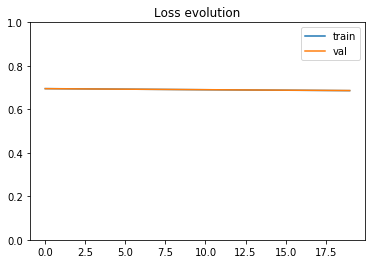

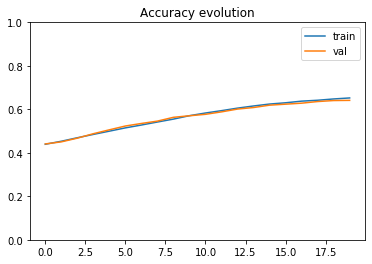

In [ ]:
plot_history(history)

In [ ]:
model_evaluation(NN_model=model, x_test=x_test_features, y_test=y_test)

5999/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

## **3. Model Optimization**

### **3.1 Batch size**

In this section, you will learn more advanced optimization methods that can speed up learning and also increase the model performances.

Different version of gradient descent can be use:
  - **Batch Descent Gradient**: we update the parameters after ***all the training examples*** have been passed through the network.

  batch size = number of training examples = N

  - **Stochastic Descent Gradient**: we update the parameters after ***one training example*** has been passed through the network.
  
  batch size = 1

  - **Mini-batch Descent Gradient**: The training dataset is divided into multiple groups and we update the paramters after ***one group example*** have been passed through the network.

  1 < batch size < N (for example 32, 64, 128, 256, 512...)

With a well-turned mini-batch size, usually it outperforms either gradient descent or stochastic gradient descent (especially when the training set is large).

![Texte alternatif…](https://github.com/Kulbear/deep-learning-coursera/raw/997fdb2e2db67acd45d29ae418212463a54be06d/Improving%20Deep%20Neural%20Networks%20Hyperparameter%20tuning,%20Regularization%20and%20Optimization/images/kiank_minibatch.png)

**TO DO**: Now, let's try to change the batch size and observe the results !

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 128)               128128    
_________________________________________________________________
dense_22 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 136,449
Trainable params: 136,449
Non-trainable params: 0
_________________________________________________________________
Train on 21595 samples, validate on 2400 samples
Epoch 1/20
21595/21595 [==============================] - 2s 82us/sample - loss: 0.6590 - accuracy: 0.6521 - val_loss: 0.6470 - val_accuracy: 0.6533
Epoch 2/20
21595/21595 [==============================] - 1s 57us/sample - loss: 0.6402 - accuracy: 0.6617 - val_loss: 0.6444 - val_accuracy: 0.6533
Epoch 3/20
21595/21595 [=======

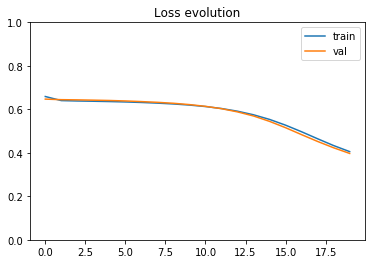

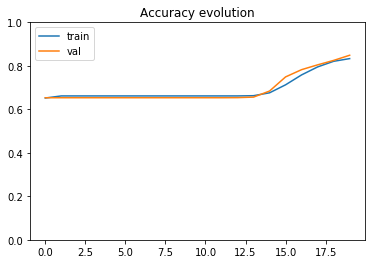

5999/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(number_of_dimensions,)))
# Adds a densely-connected layer with 64 units to the model
model.add(Dense(64, activation='relu'))
# Add a sigmoid layer with 1 output unit
model.add(Dense(1, activation='sigmoid'))
model.compile(
    loss='binary_crossentropy',
    optimizer='sgd',
    metrics=['accuracy'])

model.summary()

history = model.fit(
    x_train_features,
    y_train.values,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_split=0.1
    )

plot_history(history)

model_evaluation(NN_model=model, x_test=x_test_features, y_test=y_test)

### **3.2 Momentum**

When we use the mini-batch gradient descent, parameters are updated after seeing just a subset of examples. The direction of the update can oscillate (variance) before converging. This results in SGD being slow.

Using momentum can reduce these oscillations. Momentum is a term β added to the objective function that takes into account the past gradients to smooth out the update. The momentum term is between 0 and 1.

The larger the momentum β is, the smoother the update because the more we take the past gradients into account.
β=0 means no momentum optimization.


![Texte alternatif…](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSSw_uql2A_HVzYU3w3UbOWEJCPdmAiUieZUhgIKCQRru-yYEDR&s)


**TO DO**: Build a neural network that use Momentum


In [1]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scale = 

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 128)               128128    
_________________________________________________________________
dense_25 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 65        
Total params: 136,449
Trainable params: 136,449
Non-trainable params: 0
_________________________________________________________________
Train on 21595 samples, validate on 2400 samples
Epoch 1/20
21595/21595 [==============================] - 2s 98us/sample - loss: 0.6266 - accuracy: 0.6601 - val_loss: 0.5938 - val_accuracy: 0.6533
Epoch 2/20
21595/21595 [==============================] - 1s 56us/sample - loss: 0.4693 - accuracy: 0.7722 - val_loss: 0.3551 - val_accuracy: 0.8517
Epoch 3/20
21595/21595 [=======

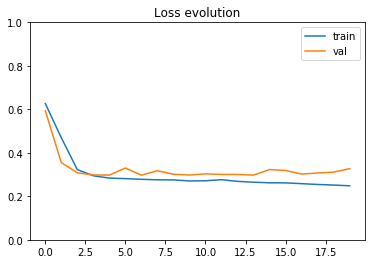

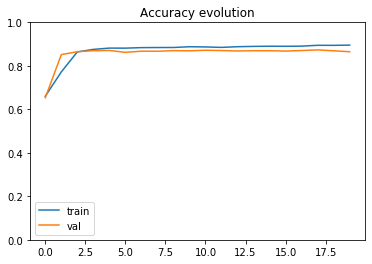

5999/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [ ]:
from tensorflow.keras import optimizers

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(number_of_dimensions,)))
# Adds a densely-connected layer with 64 units to the model
model.add(Dense(64, activation='relu'))
# Add a sigmoid layer with 1 output unit
model.add(Dense(1, activation='sigmoid'))

sgd = optimizers.SGD(momentum=0.9)
model.compile(
    loss='binary_crossentropy',
    optimizer=sgd,
    metrics=['accuracy'])

model.summary()

history = model.fit(
    x_train_features,
    y_train.values,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_split=0.1
    )

plot_history(history)

model_evaluation(NN_model=model, x_test=x_test_features, y_test=y_test)


### **3.3 RMSProp (Root Mean Square Propagation)**

RMSProp reduces the oscillation, but in a different way than momentum. RMS prop also takes away the need to adjust learning rate by dividing the gradient by an average of its recent magnitude.

**TO DO**: Create a model that use RMSProp


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 128)               128128    
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 136,449
Trainable params: 136,449
Non-trainable params: 0
_________________________________________________________________
Train on 71995 samples, validate on 8000 samples
Epoch 1/20
71995/71995 [==============================] - 6s 79us/sample - loss: 0.3158 - accuracy: 0.8627 - val_loss: 0.2789 - val_accuracy: 0.8821
Epoch 2/20
71995/71995 [==============================] - 5s 72us/sample - loss: 0.2850 - accuracy: 0.8787 - val_loss: 0.2742 - val_accuracy: 0.8855
Epoch 3/20
71995/71995 [=======

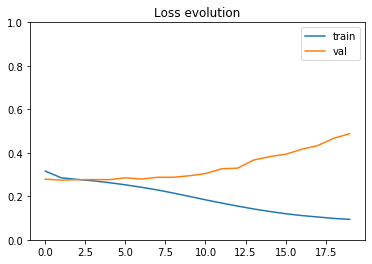

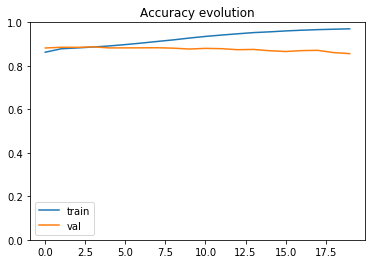

19999/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(number_of_dimensions,)))
# Adds a densely-connected layer with 64 units to the model
model.add(Dense(64, activation='relu'))
# Add a sigmoid layer with 1 output unit
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy'])

model.summary()

history = model.fit(
    x_train_features,
    y_train.values,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_split=0.1
    )

plot_history(history)

model_evaluation(NN_model=model, x_test=x_test_features, y_test=y_test)


### **3.4 ADAM (Ddaptive Moment Estimation)**

Adam optimizer is one of the most popular gradient descent optimization. 
This method combines momentum and RMSprop. Indeed, it introduces new parameters: 
  - β from momentum 
  - β2 from RMSprop

**TO DO**: Build a neural network that use Adam optimization

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 128)               128128    
_________________________________________________________________
dense_28 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 65        
Total params: 136,449
Trainable params: 136,449
Non-trainable params: 0
_________________________________________________________________
Train on 21595 samples, validate on 2400 samples
Epoch 1/20
21595/21595 [==============================] - 2s 82us/sample - loss: 0.3741 - accuracy: 0.8244 - val_loss: 0.2983 - val_accuracy: 0.8692
Epoch 2/20
21595/21595 [==============================] - 1s 59us/sample - loss: 0.2818 - accuracy: 0.8815 - val_loss: 0.3023 - val_accuracy: 0.8629
Epoch 3/20
21595/21595 [=======

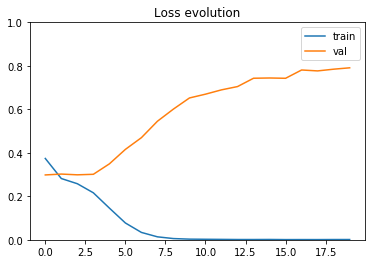

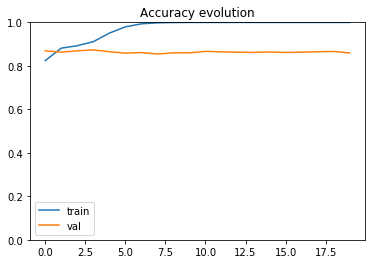

5999/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(number_of_dimensions,)))
# Adds a densely-connected layer with 64 units to the model
model.add(Dense(64, activation='relu'))
# Add a sigmoid layer with 1 output unit
model.add(Dense(1, activation='sigmoid'))

adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(
    loss='binary_crossentropy',
    optimizer=adam,
    metrics=['accuracy'])

model.summary()

history = model.fit(
    x_train_features,
    y_train.values,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_split=0.1
    )

plot_history(history)

model_evaluation(NN_model=model, x_test=x_test_features, y_test=y_test)

The accuracy on the train set is much higher compare to the test set... The model is actually overfitting !

![Texte alternatif…](https://miro.medium.com/max/2250/1*_7OPgojau8hkiPUiHoGK_w.png)


## **4. Regularization techniques**


The non-regularized model is overfitting the training set. Lets now look at 3 different techniques to reduce overfitting.

### **4.1 L2 regularization**

The standard way to avoid overfitting is called L2 regularization. It consists of appropriately modifying your cost function, from: $$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} \tag{1}$$ To: $$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost} \tag{2}$$

Let's modify the cost using the *kernel_regularizer* parameter !


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 128)               128128    
_________________________________________________________________
dense_31 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 65        
Total params: 136,449
Trainable params: 136,449
Non-trainable params: 0
_________________________________________________________________
Train on 21595 samples, validate on 2400 samples
Epoch 1/20
21595/21595 [==============================] - 2s 97us/sample - loss: 0.6323 - accuracy: 0.7899 - val_loss: 0.4386 - val_accuracy: 0.8408
Epoch 2/20
21595/21595 [==============================] - 1s 65us/sample - loss: 0.4044 - accuracy: 0.8524 - val_loss: 0.4004 - val_accuracy: 0.8521
Epoch 3/20
21595/21595 [======

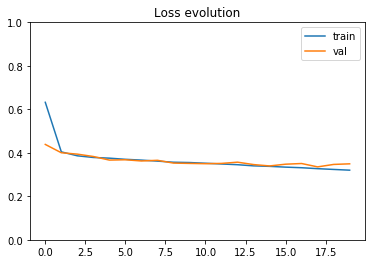

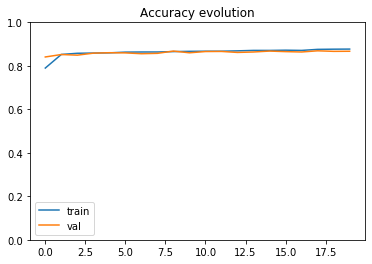

5999/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [ ]:
model = Sequential()
# Add regularizer on layer parameter
model.add(Dense(128,  kernel_regularizer=regularizers.l2(0.01), input_shape=(number_of_dimensions,), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

model.summary()

history = model.fit(
    x_train_features,
    y_train.values,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_split=0.1
    )

plot_history(history)

model_evaluation(NN_model=model, x_test=x_test_features, y_test=y_test)

### **4.2 Dropout**

Finally, dropout is a widely used regularization technique that is specific to deep learning. It randomly shuts down some neurons in each iteration. Watch these two videos to see what this means!

When you shut some neurons down, you actually modify your model. The idea behind drop-out is that at each iteration, you train a different model that uses only a subset of your neurons. With dropout, your neurons thus become less sensitive to the activation of one other specific neuron, because that other neuron might be shut down at any time.

![Texte alternatif…](https://camo.githubusercontent.com/06e05aa7d7cd9803221f4a7f0c113aa0bf6a97b4/68747470733a2f2f7777772e64726f70626f782e636f6d2f732f347a36646636656a393075687935352f64726f706f75742e706e673f7261773d31)

Dropout is regulate by the *rate* parameter. For example, if rate is 0.5, then we will on average shut down half the nodes of the network.

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 128)               128128    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 65        
Total params: 136,449
Trainable params: 136,449
Non-trainable params: 0
_________________________________________________________________
Train on 21595 samples, validate on 2400 samples
Epoch 1/20
21595/21595 [==============================] - 2s 93u

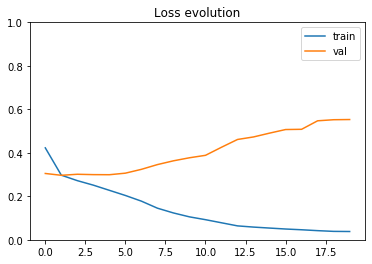

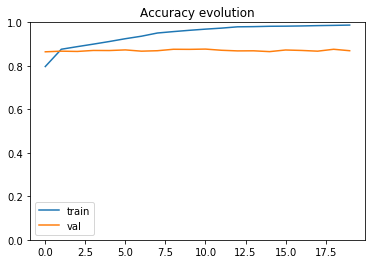

5999/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [ ]:
from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(Dense(128, input_shape=(number_of_dimensions,), activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

model.summary()

history = model.fit(
    x_train_features,
    y_train.values,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_split=0.1
    )

plot_history(history)

model_evaluation(NN_model=model, x_test=x_test_features, y_test=y_test)

#### **Batch normalization**

Batch normalization is a technique use to improve the speed, the performance and the stability of the model.

During the training step, the distribution of the inputs to layers deep in the network may change after each mini-batch.

Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. (by subtracting the batch mean and dividing by the batch standard deviation). It consequently stabilize the learning process and reduces the training time.

Batch normalization allows the usage of higher learner rates.




Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 128)               128128    
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_37 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 65        
Total params: 137,217
Trainable params: 136,833
Non-trainable params: 384
_________________________________________________________________
Train on 21595 samples, validate on 2400 samples
Epoch 1/20
21595/21595 [==============================] - 3s 1

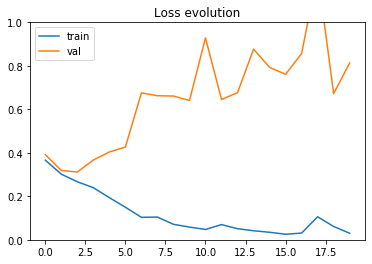

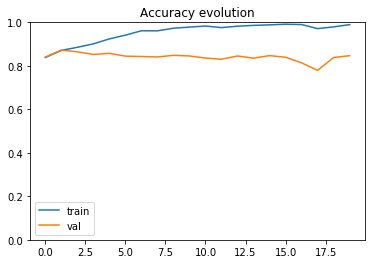

5999/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [ ]:
from tensorflow.keras.layers import BatchNormalization

model = Sequential()
model.add(Dense(128, input_shape=(number_of_dimensions,), activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

adam = optimizers.Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.999)
model.compile(
    loss='binary_crossentropy',
    optimizer=adam,
    metrics=['accuracy'])

model.summary()

history = model.fit(
    x_train_features,
    y_train.values,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_split=0.1
    )

plot_history(history)

model_evaluation(NN_model=model, x_test=x_test_features, y_test=y_test)

#### **Early Stopping**

The early stopping method allow to stop the training when a monitored quantity has stopped improving. We can use this regularization method to avoid overfitting.

**TO DO**: Train a model using early stopping


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 128)               128128    
_________________________________________________________________
dense_40 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 65        
Total params: 136,449
Trainable params: 136,449
Non-trainable params: 0
_________________________________________________________________
Train on 21595 samples, validate on 2400 samples
Epoch 1/20
21595/21595 [==============================] - 2s 85us/sample - loss: 0.3692 - accuracy: 0.8420 - val_loss: 0.3136 - val_accuracy: 0.8571
Epoch 2/20
21595/21595 [==============================] - 1s 62us/sample - loss: 0.3047 - accuracy: 0.8721 - val_loss: 0.3200 - val_accuracy: 0.8583
Epoch 3/20
21595/21595 [======

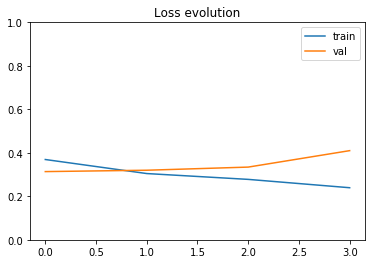

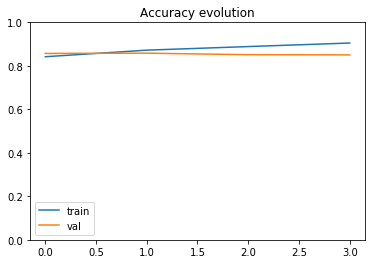

5999/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [ ]:
from tensorflow.keras import callbacks
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)


model = Sequential()
model.add(Dense(128, input_shape=(number_of_dimensions,), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

adam = optimizers.Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.999)
model.compile(
    loss='binary_crossentropy',
    optimizer=adam,
    metrics=['accuracy'])

model.summary()

history = model.fit(
    x_train_features,
    y_train.values,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_split=0.1,
    callbacks=[early_stopping]
    )

plot_history(history)

model_evaluation(NN_model=model, x_test=x_test_features, y_test=y_test)

## **5. Exercice**

Use everything you have learned to create the best model by optimizing all the different parameters:
  - tf-idf
  - number of layers
  - numer of neurone
  - batch size
  - learning rate
  - number of epochs
  - optimizer
  - regularization
  - ...

In [ ]:
# Parameters
DATA_SAMPLE_SIZE = 100000
NUMBER_OF_DIMENSIONS = 1000 # tfidf input
TARGET = 'bin_rating'
FEATURE = 'review'

In [ ]:
# Read data
df_data = pd.read_csv("./data/train_set.csv")
df_data = df_data[0:DATA_SAMPLE_SIZE]

# Remove empty review
df_data = df_data[['review', 'rating']].dropna()

# Convert target as integer
df_data['rating'] = df_data['rating'].astype('int')

# Create the new binary target
df_data['bin_rating'] = df_data['rating'].apply(lambda x: 1 if x > 3 else 0)

# clean the text
df_cleaned = text_cleaning(df_data, 'review')

# Split train test
x_train, x_test, y_train, y_test = train_test_split(
    df_cleaned[FEATURE], 
    df_cleaned[TARGET], 
    test_size=0.2,
    random_state=2019)

# Tfidf vectorization
tfidf_vectorizer = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 1),
    max_features=NUMBER_OF_DIMENSIONS,
    max_df=1.0,
    min_df=10)


tfidf_vectorizer.fit(x_train)

x_train_features = tfidf_vectorizer.transform(x_train).toarray()
x_test_features = tfidf_vectorizer.transform(x_test).toarray()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 128)               128128    
_________________________________________________________________
dense_52 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 65        
Total params: 136,449
Trainable params: 136,449
Non-trainable params: 0
_________________________________________________________________
Train on 71995 samples, validate on 8000 samples
Epoch 1/10
71995/71995 [==============================] - 3s 48us/sample - loss: 1.4718 - accuracy: 0.6557 - val_loss: 0.7018 - val_accuracy: 0.7628
Epoch 2/10
71995/71995 [==============================] - 3s 41us/sample - loss: 0.4989 - accuracy: 0.8393 - val_loss: 0.3885 - val_accuracy: 0.8766
Epoch 3/10
71995/71995 [======

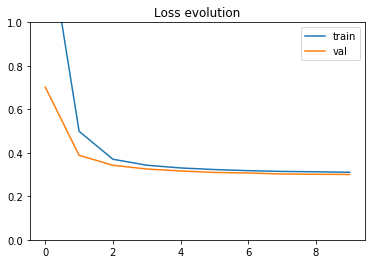

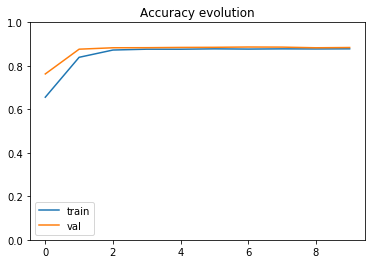

19999/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [ ]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)


model = Sequential()
# Add regularizer on layer parameter
model.add(Dense(128,  kernel_regularizer=regularizers.l2(0.01), input_shape=(number_of_dimensions,), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

adam = optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(
    loss='binary_crossentropy',
    optimizer=adam,
    metrics=['accuracy'])

model.summary()

history = model.fit(
    x_train_features,
    y_train.values,
    batch_size=128,
    epochs=10,
    verbose=1,
    validation_split=0.1,
    callbacks=[early_stopping]
    )

plot_history(history)

model_evaluation(NN_model=model, x_test=x_test_features, y_test=y_test)

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_96 (Dense)             (None, 256)               256256    
_________________________________________________________________
dense_97 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_98 (Dense)             (None, 1)                 65        
Total params: 272,769
Trainable params: 272,769
Non-trainable params: 0
_________________________________________________________________
Train on 78395 samples, validate on 1600 samples
Epoch 1/30
78395/78395 [==============================] - 8s 96us/sample - loss: 0.3495 - accuracy: 0.8597 - val_loss: 0.3028 - val_accuracy: 0.8881
Epoch 2/30
78395/78395 [==============================] - 7s 89us/sample - loss: 0.3068 - accuracy: 0.8784 - val_loss: 0.2950 - val_accuracy: 0.8913
Epoch 3/30
78395/78395 [======

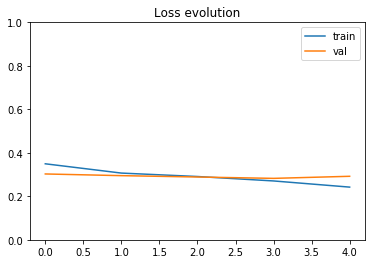

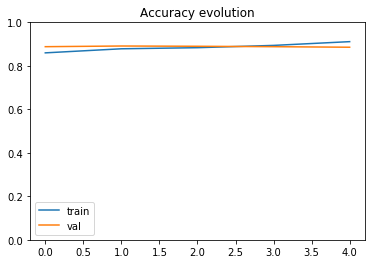

19999/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [ ]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=1, verbose=1)


model = Sequential()
# Add regularizer on layer parameter
model.add(Dense(256,  kernel_regularizer=regularizers.l2(0.0001), input_shape=(number_of_dimensions,), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

adam = optimizers.Adam(learning_rate=0.0005, beta_1=0.8, beta_2=0.999)
model.compile(
    loss='binary_crossentropy',
    optimizer=adam,
    metrics=['accuracy'])

model.summary()

history = model.fit(
    x_train_features,
    y_train.values,
    batch_size=64,
    epochs=30,
    verbose=1,
    validation_split=0.02,
    callbacks=[early_stopping]
    )

plot_history(history)

model_evaluation(NN_model=model, x_test=x_test_features, y_test=y_test)